In [88]:
data_link = '../dataset'
model_link = '../model'

In [89]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tabulate import tabulate

import os
import cv2
from tqdm import tqdm
import numpy as np

tf.random.set_seed(42)

In [90]:
class Train:
    def __init__(self, data_link):
        self.data_link = data_link
    def total_img(self):
        total = 0
        for label in os.listdir(self.data_link):
            total += len(os.listdir(os.path.join(self.data_link, label)))
        return total
    def char2stt(self, char):
        return int(ord(char) - ord('A'))
    def prepare_data(self):
        self.x, self.y = [], []
        labels = os.listdir(self.data_link)
        total = self.total_img()
        I = np.eye(26)
        sub_size = int(np.ceil(np.sqrt(len(labels))))
        plt.figure(figsize=(2*sub_size, 2*sub_size))
        with tqdm(total=total, desc='Loading data') as pbar:
            for i, label in enumerate(labels, start=1):
                label_path = os.path.join(self.data_link, label)
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    image = cv2.resize(image, (75, 100))
                    image = np.expand_dims(image, axis=-1)
                    image = image / 255.0
                    self.x.append(image)
                    self.y.append(I[self.char2stt(label)])
                    pbar.update(1)
                plt.subplot(sub_size, sub_size, i)
                plt.title(f'Char [{label}]', color='white')
                plt.gcf().set_facecolor('black') 
                plt.axis('off')
                plt.imshow(image, cmap='gray')
        self.x, self.y = np.array(self.x), np.array(self.y)
        header = ['name', 'shape']
        data = [
            ['x', self.x.shape],
            ['y', self.y.shape],
        ]
        print(tabulate(data, headers=header, tablefmt="simple_grid"))
    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.1, random_state=42)
        header = ['name', 'shape']
        data = [
            ['x_train', self.x_train.shape],
            ['x_test', self.x_test.shape],
            ['y_train', self.y_train.shape],
            ['y_test', self.y_test.shape],
        ]
        print(tabulate(data, headers=header, tablefmt="simple_grid"))
    def prepare_model(self):
        self.model = Sequential([
            ZeroPadding2D(padding=((1, 1), (1, 1)), input_shape=(75, 100, 1)),
            Conv2D(96, (11, 11), strides=(2, 2), activation='relu'),
            MaxPooling2D((3, 3)),
            ZeroPadding2D(padding=((2, 2), (2, 2))),
            Conv2D(256, (5, 5), strides=(1, 1), activation='relu'),
            MaxPooling2D((3, 3)),
            ZeroPadding2D(padding=((1, 1), (1, 1))),
            Conv2D(384, (3, 3), activation='relu'),
            MaxPooling2D((3, 3)),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.1),
            Dense(26, activation='softmax'),
        ])
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    def train(self, epochs, batch_size):
        return self.model.fit(
            self.x_train,
            self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.x_test, self.y_test),
            shuffle=True
        )


Loading data: 100%|██████████| 2400/2400 [00:01<00:00, 1918.71it/s]


┌────────┬────────────────────┐
│ name   │ shape              │
├────────┼────────────────────┤
│ x      │ (2400, 100, 75, 1) │
├────────┼────────────────────┤
│ y      │ (2400, 26)         │
└────────┴────────────────────┘


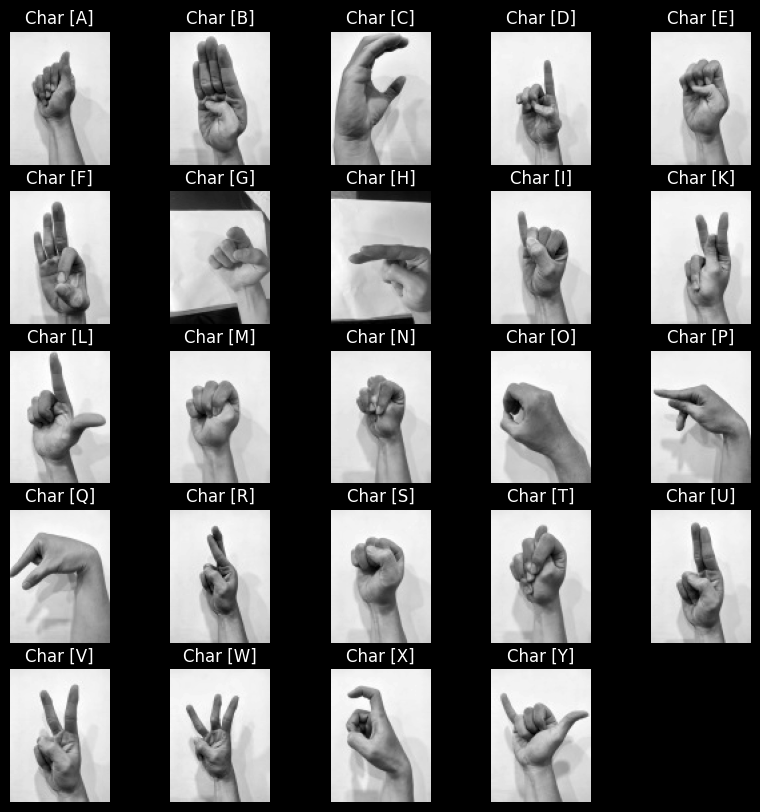

In [91]:
model = Train(data_link=data_link)

model.prepare_data()

In [92]:
model.split_data()
model.prepare_model()

┌─────────┬────────────────────┐
│ name    │ shape              │
├─────────┼────────────────────┤
│ x_train │ (2160, 100, 75, 1) │
├─────────┼────────────────────┤
│ x_test  │ (240, 100, 75, 1)  │
├─────────┼────────────────────┤
│ y_train │ (2160, 26)         │
├─────────┼────────────────────┤
│ y_test  │ (240, 26)          │
└─────────┴────────────────────┘


c:\Users\nhann\.conda\envs\env1\lib\site-packages\keras\src\layers\reshaping\zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [93]:
history = model.train(epochs=25, batch_size=32)

Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.0375 - loss: 3.2410 - val_accuracy: 0.0292 - val_loss: 3.2290
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.0404 - loss: 3.2067 - val_accuracy: 0.0292 - val_loss: 3.2174
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.0531 - loss: 3.1786 - val_accuracy: 0.0458 - val_loss: 3.0553
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.1030 - loss: 2.9605 - val_accuracy: 0.1750 - val_loss: 2.5130
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.2462 - loss: 2.3585 - val_accuracy: 0.3875 - val_loss: 1.7580
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.4663 - loss: 1.6642 - val_accuracy: 0.6292 - val_loss: 1.1407
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6627 - loss: 1.0214 - val_accuracy: 0.7500 - val_loss: 0.8113
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7675 - loss: 0.6950 - val_accuracy: 0.7917 - v

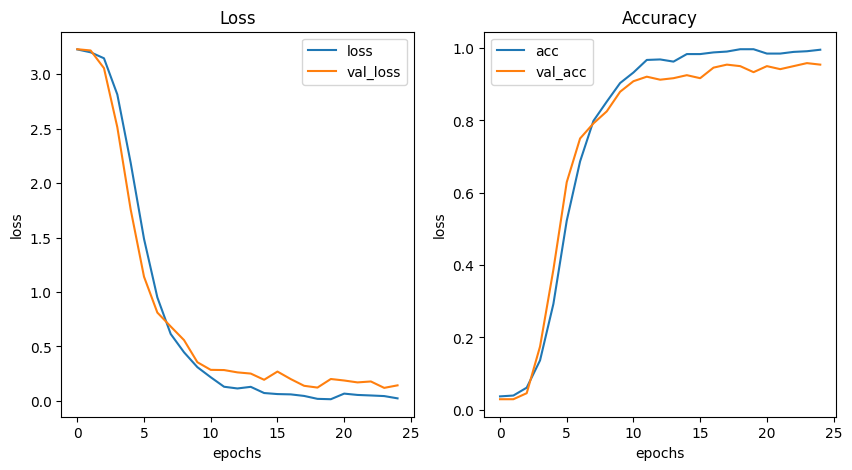

In [98]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()


In [99]:
def stt2char(num):
    return chr(int(num) + ord('A'))

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


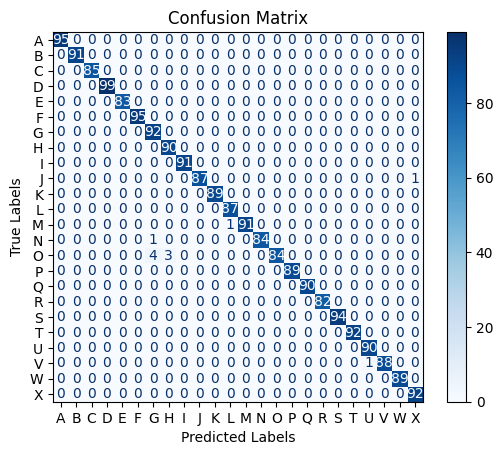

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = np.argmax(model.model.predict(model.x_train), axis=1)
true_labels = np.argmax(model.y_train, axis=1)


cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
labels = [stt2char(i) for i in range(cm.shape[0])]
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=np.arange(cm.shape[1]), labels=labels)
plt.yticks(ticks=np.arange(cm.shape[0]), labels=labels)
plt.show()

In [101]:
model_name = 'model_3.h5'
model.model.save(os.path.join(model_link, model_name))